In [1]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
META_DIR = Path('../data/fma_metadata')
AUDIO_DIR = Path('../data/fma_small')
CONVERTED_DIR = Path('../data/converted/rock_inst')

In [6]:
tracks = pd.read_csv(META_DIR/'tracks.csv', index_col=0, header=[0, 1]) 

In [18]:
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                                                            \
         producer tags                 title tracks   type   
track_id                                                     
2             NaN   []  AWOL - A Way Of Life      7  Album   
3             NaN   []  AWOL - A Way Of Life      7  Album   
5             NaN   []  AWOL - A Way Of Life      7  Album   
10            NaN   []     Constant Hitmaker      2  Album   
20            NaN   []                 Niris     13  Album   

                       artist                       \
            active_year_begin      active_year_end   
track_id                                             
2         2006-01-01 00:00:00                  NaN   
3         2006-01-01 00:00:00                  NaN   
5         2006-01-01 00:00:00                  NaN   
10                        NaN                  NaN   
20        1990-01-01 00:00:00  2011-01-01 00:00:00   

                                                             \
                                          associated_labels   
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                                      \
                                                        bio comments   
track_id                                                               
2         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
10        <p><span style="font-family:Verdana, Geneva, A...        3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...        2   

                                                                           \
                 date_created favorites id   latitude            location   
track_id                                                                    
2         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
3         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
5         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
10        2008-11-26 01:42:55        74  6        NaN                 NaN   
20        2008-11-26 01:42:52        10  4  51.895927  Colchester England   

                                                                        \
          longitude                                            members   
track_id                                         

#### Keep relevant columns

In [19]:

keep_cols = [('set', 'split'), ('set', 'subset'), ('artist', 'name'), ('track', 'title'), ('track', 'genre_top')]
df_all = tracks[keep_cols]

# Move index to track_id column
df_all['track_id'] = df_all.index

#### Get small and medium metadata

In [20]:
df_small = df_all[df_all[('set', 'subset')] == 'small']
df_med = df_all[df_all[('set', 'subset')] == 'medium']

In [21]:
print('Length of small dataset: ', len(df_small))
df_small[('track', 'genre_top')].value_counts()

Length of small dataset:  8000


Folk             1000
Hip-Hop          1000
International    1000
Rock             1000
Electronic       1000
Experimental     1000
Pop              1000
Instrumental     1000
Name: (track, genre_top), dtype: int64

In [23]:
print('Length of medium dataset: ', len(df_med))
# df_med[('track', 'genre_top')].value_counts()

Length of medium dataset:  17000


### Get songs that are listed more than once, and are not in the training data

In [31]:
counts = df_small[('track', 'title')].value_counts()
mask = counts > 1
dup_songs = counts[mask].index
dup_mask = df_small[('track', 'title')].isin(dup_songs)

In [39]:
not_train = df_small[df_small[('set', 'split')] != 'training']

not_train = not_train[dup_mask].sort_values(('track', 'title'))

### Filter by genre

In [39]:
genre_mask = not_train[('track', 'genre_top')] == 'Rock'
not_train[genre_mask]

set                   artist               track            \
               split subset              name               title genre_top   
track_id                                                                      
127559          test  small          Droopies          High Hopes      Rock   
141877          test  small  Nocturnal Mayhem                   I      Rock   
141878          test  small  Nocturnal Mayhem                  II      Rock   
50449     validation  small        Milk Music           Interview      Rock   
13556     validation  small             STEEP           Let Me Go      Rock   
73520           test  small    Hounds Of Hate               Pride      Rock   
28070           test  small        Bare Wires       Romantic Girl      Rock   
47526           test  small        Bare Wires       Romantic Girl      Rock   
82462           test  small    Throwing Muses            Stand Up      Rock   
28274     validation  small            Sultan  There Goes My Girl      Rock   
68909     validation  small      Inperfektion             Walking      Rock   

         track_id  
                   
track_id           
127559     127559  
141877     141877  
141878     141878  
50449       50449  
13556       13556  
73520       73520  
28070       28070  
47526       47526  
82462       82462  
28274       28274  
68909       68909

In [9]:
rock = df_small[('track', 'genre_top')] == 'Rock'
hiphop = df_small[('track', 'genre_top')] == 'Hip-Hop'


two_genre = df_small[mask]

## Create train, validation and test subsets

In [11]:
df_train = two_genre[two_genre[('set', 'split')] == 'training'  ]
df_valid = two_genre[two_genre[('set', 'split')] == 'validation']
df_test  = two_genre[two_genre[('set', 'split')] == 'test'      ]

# Load and check npz files

In [3]:
npzfile = np.load(CONVERTED_DIR/'train_arr.npz')
X_train = npzfile['X']
y_train = npzfile['y']
print(X_train.shape, y_train.shape)

(1599, 640, 128) (1599,)


In [4]:
mask = y_train == 0
rock = X_train[mask]

In [5]:
rock[0]

array([[-37.23766708, -32.22536469, -31.2519455 , ..., -80.        ,
        -80.        , -80.        ],
       [-31.67321014, -26.83535767, -25.70909119, ..., -80.        ,
        -80.        , -80.        ],
       [-27.22371292, -18.4656601 , -15.39180374, ..., -78.87762451,
        -80.        , -80.        ],
       ...,
       [-57.42717361, -52.34672165, -27.42918205, ..., -45.95634842,
        -48.37863159, -59.77183533],
       [-51.93827057, -50.4214592 , -21.3014431 , ..., -43.42111206,
        -47.77090073, -58.31129456],
       [-47.62976837, -47.69284439, -20.78324509, ..., -41.72824097,
        -46.9524765 , -60.10992432]])

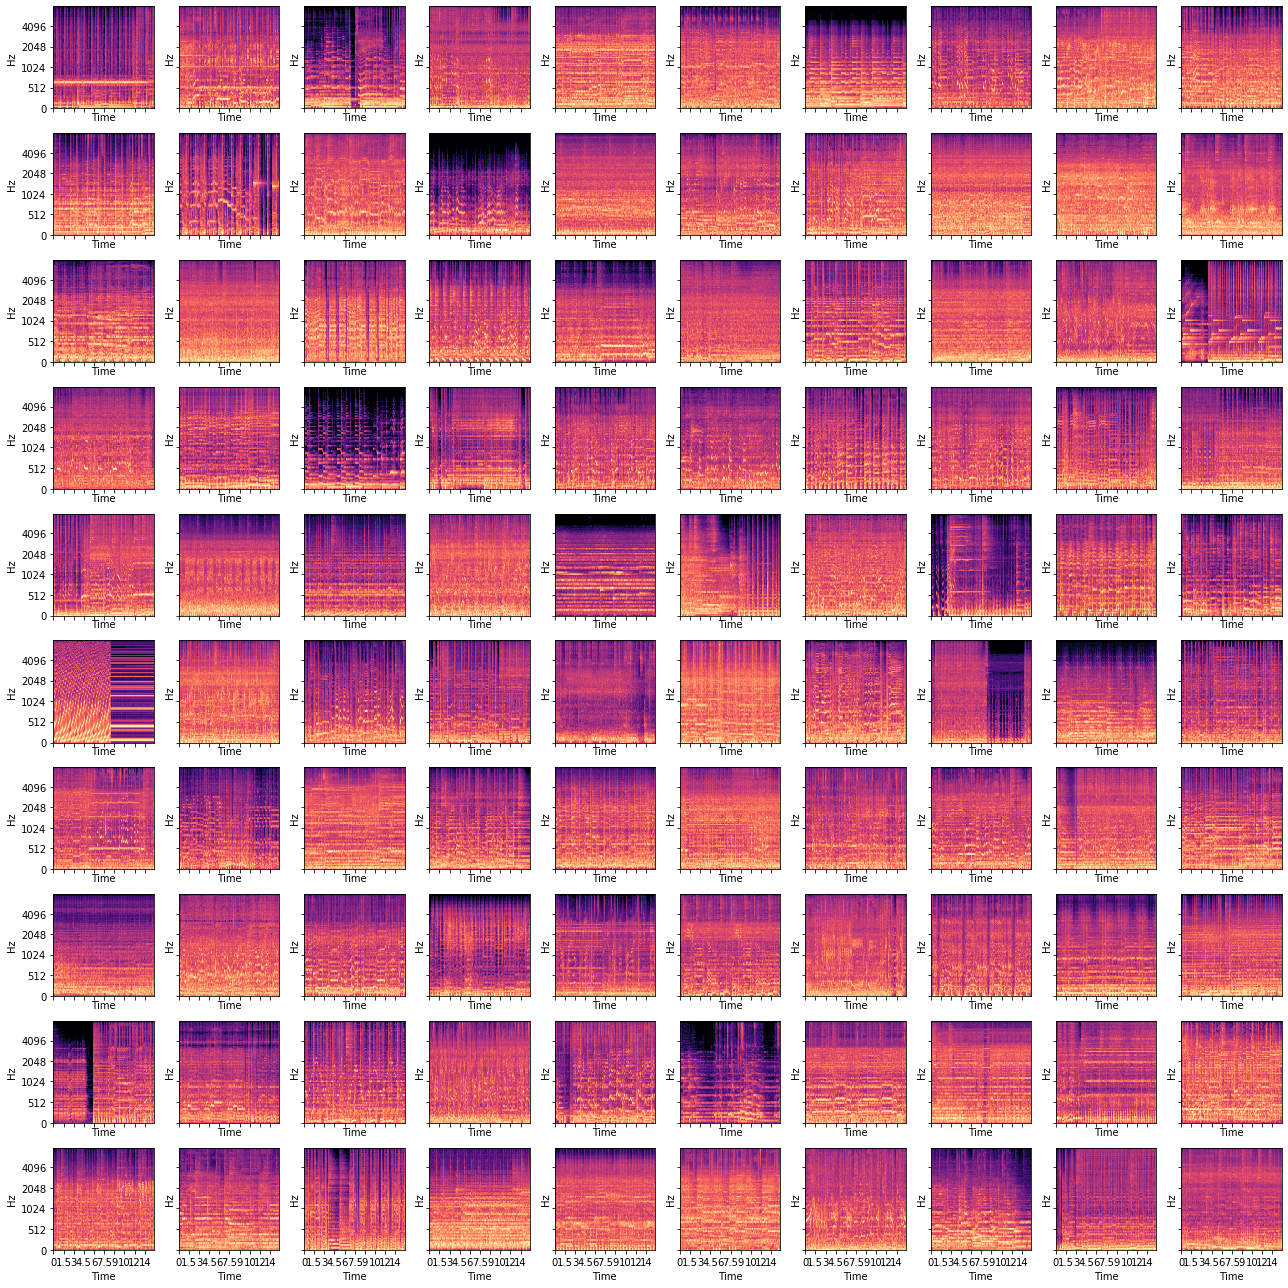

In [7]:
fig, axes = plt.subplots(10,10, figsize=(18,18), sharey=True, sharex=True)

for i, ax in enumerate(axes.flatten()):
    librosa.display.specshow(rock[i].T, y_axis='mel', fmax=8000, x_axis='time', ax=ax)
plt.tight_layout()

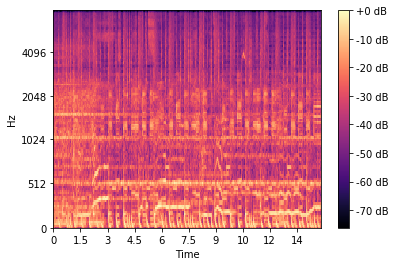

In [15]:
librosa.display.specshow(X_train[1].T, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [16]:
print(X_train[1].min(), X_train[1].max())

-76.22682189941406 0.0


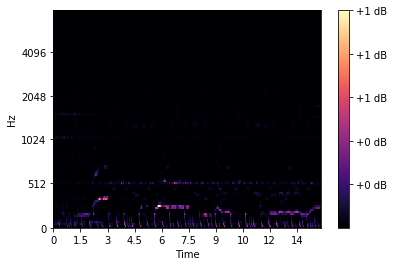

In [12]:
X_raw = librosa.core.db_to_power(X_train[1], ref=1.0)
librosa.display.specshow(X_raw.T, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [10]:
print(X_raw.min(), X_raw.max())

2.3840634523369956e-08 1.0


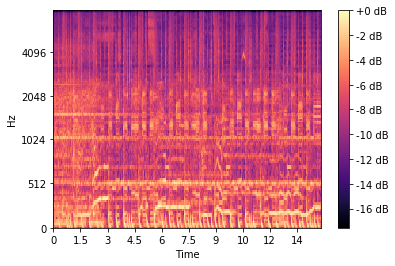

In [13]:
X_log = np.log(X_raw)
librosa.display.specshow(X_log.T, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')

In [14]:
print(X_log.min(), X_log.max())

-17.55187437919029 0.0


# May need to concatenate and shuffle when adding new genres

In [1]:
# Example of concatenation
X_train = np.concatenate((X_train1, X_train2, X_train3, X_train4), axis = 0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis = 0)
print(X_train.shape, y_train.shape)

NameError: name 'np' is not defined

In [2]:
def shuffle(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

In [ ]:

# Example of shuffle
X_shuf, y_shuf = shuffle(X_train, y_train)

# Creating conversion script

In [3]:
META_DIR = Path('../data/fma_metadata')

In [4]:
GENRES = ['Rock', 'Hip-Hop']
AUDIO_DIR = Path('../data/fma_small')
SIZE = 'small'
SPLITS = ['train', 'validation', 'test']

In [5]:
TRACKS = pd.read_csv(META_DIR/'tracks.csv', index_col=0, header=[0, 1])
keep_cols = [('set', 'split'), ('set', 'subset'),('track', 'genre_top')]
TRACKS = TRACKS[keep_cols]
TRACKS = TRACKS[TRACKS[('set', 'subset')] == SIZE]
TRACKS['track_id'] = TRACKS.index

In [6]:
def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')

In [7]:
def get_genre_df():
    genre_mask = TRACKS[('track', 'genre_top')].isin(GENRES)
    return TRACKS[genre_mask]

In [8]:
# def get_split_df(split):
#     split_mask = TRACKS[('set', 'split')] == split
#     return TRACKS[split_mask]

In [9]:
def create_spectrogram(track_id):
    '''
    Create transposed melspectrogram, normalized

    Parameters
    ----------
    track_id : int
        Track number without leading zeros

    Returns
    -------
    np.array
        Transposed melspectrogram, normalized
    '''
    filename = get_audio_path(AUDIO_DIR, track_id)
    y, sr = librosa.load(filename)
    spect = librosa.feature.melspectrogram(y=y, sr=sr,n_fft=2048, hop_length=512)
    spect = librosa.power_to_db(spect, ref=np.max)
    return (spect + 80) / 80

In [27]:
# Modified from https://github.com/priya-dwivedi/Music_Genre_Classification/
def create_arrays(df, verbose=True):
    '''
    Creates numpy arrays (melspectrograms) of tracks in dataframe.
    Saves in directory corresponding to split/genre in dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe representing one size of the dataset
        (small, medium, large)
    verbose : bool
        Print status updates during conversion.

    Returns
    -------
    list
        shapes of all spectrograms before adjustments
    '''
    shapes = []
    total = len(df)
    count = 0
    
    for _, row in df.iterrows():
        # Skips records in case of errors
        try:
            count += 1

            # Get metadata
            track_id = int(row['track_id'])
            genre = str(row[('track', 'genre_top')])
            split = str(row[('set', 'split')])

            # Create spectrogram
            spect = create_spectrogram(track_id)

            # Store shape
            shapes.append([track_id, spect.shape[0], spect.shape[1]])

            # Adjust for shape differences
            spect = spect[:, :640]

            # Save to appropriate folder
            fname = './{}/{}/{:06d}.npy'.format(split, genre, track_id)
            np.save(fname, spect)

            if verbose:
                if count%100 == 0:
                    print("Processed {} of {}"
                          .format(count, total))
        except:
            if verbose:
                print("Couldn't process: {} of {} - track {}"
                      .format(count, total, track_id))
            continue

    return shapes

In [28]:
df = get_genre_df()

In [29]:
shapes = create_arrays(df[:10])

Couldn't process: 8 of 10 - track 574
Couldn't process: 10 of 10 - track 690


In [31]:
pd.DataFrame(shapes)

,0,1,2
0,2,128,1292
1,5,128,1293
2,182,128,1293
3,255,128,1292
4,256,128,1292
5,368,128,1292
6,459,128,1293
7,676,128,1292


In [65]:
# shapes = pd.DataFrame(columns=['track_id', 'length', 'width'])
shapes = []

In [66]:
for i in [2,5]:
    spect = create_spectrogram(i)
    shapes.append([i, spect.shape[0], spect.shape[1]])

In [34]:
'_'.join(str(shapes[0]))

'[_2_,_ _1_2_8_,_ _1_2_9_2_]'

In [35]:
'_'.join(['asdfsd','f','t'])

'asdfsd_f_t'

In [37]:
from datetime import datetime

a = datetime.now()

In [48]:
elapsed = datetime.now() - a
'{} minutes'.format(elapsed.seconds/60)

'8.25 minutes'